In [1]:
from googleapiclient.discovery import build
from youtube_interface import PyTubeClient
import pandas as pd
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
load_dotenv('./.env', override=True)
import os
import json

In [2]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
api_service_name = "youtube"
api_version = "v3"
api_key = os.environ['YT_API_KEY']
channel_id = 'TomBilyeu'

In [3]:
import os

import googleapiclient.discovery
import googleapiclient.errors

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]


    # Get credentials and create an API client
youtube = build('youtube', 'v3', developerKey=api_key)
request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    forUsername=channel_id)
    # forUsername="fivethirtyeight")

response = request.execute()
response

{'kind': 'youtube#channelListResponse',
 'etag': 'RuuXzTIr0OoDqI4S0RU6n4FqKEM',
 'pageInfo': {'totalResults': 0, 'resultsPerPage': 5}}

In [12]:

# channel_ids = ['UCnz-ZXXER4jOvuED5trXfEA', # techTFQ
#                'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse 
#                'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
#                'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
#                'UC2UXDak6o7rBm23k3Vv5dww' # Tina Huang
#               ]

In [5]:
response['kind']

'youtube#channelListResponse'

In [7]:
channel_id = 'UCnYMOamNKLGVlJgRUbamveA'

In [28]:
response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

'UUFTSB49Ut6hNt08IdfS5UbA'

## Function to get channel statistics

In [8]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=channel_ids) #','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return all_data

In [9]:
channel_statistics = get_channel_stats(youtube, channel_id)

In [10]:
channel_data = pd.DataFrame(channel_statistics)

In [19]:
channel_statistics

[{'Channel_name': 'Tom Bilyeu',
  'Subscribers': '3850000',
  'Views': '386495450',
  'Total_videos': '1049',
  'playlist_id': 'UUnYMOamNKLGVlJgRUbamveA'}]

## Function to get video ids

In [12]:
# playlist_id = channel_data.playlist_id.values.tolist()[0]
# playlist_id = "PLAiITlQWhsRTcIw_C4SHr0y_WqogzR8lR"
impact_playlist_id = "PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo"

In [13]:
def get_video_ids(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 500)
    response = request.execute()
    video_ids = []
    
    items = response['items']
    for i in range(len(items)):
        video_ids.append(items[i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    if next_page_token:
        more_pages = True
        page_count = 1
    
    while more_pages:
        page_count += 1
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        page_response = request.execute()
        
        for i in range(len(page_response['items'])):
            video_ids.append(page_response['items'][i]['contentDetails']['videoId'])
        print(f'Total pages ripped: {page_count}')
        next_page_token = page_response.get('nextPageToken', False)
        if not next_page_token:
            more_pages = next_page_token
        
    return video_ids

In [14]:
video_ids = get_video_ids(youtube, impact_playlist_id)

Total pages ripped: 2
Total pages ripped: 3
Total pages ripped: 4
Total pages ripped: 5
Total pages ripped: 6
Total pages ripped: 7
Total pages ripped: 8


In [24]:
vid_df = pd.DataFrame(video_ids)
vid_df.to_csv('/home/elastic/notebooks/vector_search_applications/practice_data/impact_theory_video_ids.csv', index=False, header=False)

In [13]:
with open('./data/impact_theory_metadata.json') as f:
    data = json.loads(f.read())

In [23]:
start = 387
for i in range(len(video_ids)):
    episode = start - i + 1
    video_id = video_ids[i]
    for d in data:
        if d['video_id'] == video_id:
            d.update(episode_num=episode)
    

In [28]:
client = PyTubeClient('fake')
client.save_meta_toJSON(data, out_path='/home/elastic/notebooks/vector_search_applications/data/impact_theory_metadata.json')

2023-09-13 19:54:25.225 | INFO     | youtube_interface:save_meta_toJSON:195 - Metadata saved as: /home/elastic/notebooks/vector_search_applications/data/impact_theory_metadata.json.


## Function to get video details

In [16]:
def get_video_details(youtube, video_ids: list):
    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part='snippet,statistics',
                    id=','.join(video_ids[i:i+50]))
        response = request.execute()
        
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount']
                               )
            all_video_stats.append(video_stats)
    
    return response['items']

In [17]:
video_details = get_video_details(youtube, video_ids)

In [20]:
# video_details

In [148]:
video_data = pd.DataFrame(video_ids, columns=['Video_Ids'])

In [21]:
# video_data.to_csv('./video_ids_538.csv', index=False)

In [19]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Dislikes'] = pd.to_numeric(video_data['Dislikes'])
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data

,Title,Published_date,Views,Likes,Dislikes,Comments
0,#66DaysOfData Round 3 Live Event! (feat. @Stat...,2021-10-12,1222,108,0,3
1,My First Data Science Project (What Really Hap...,2021-10-08,2123,154,0,56
2,Is Data Visualization Important for Data Scien...,2021-08-20,9180,444,1,115
3,Project Presentation - Expectations vs. Realit...,2021-08-07,4421,162,2,36
4,Data Science Project - Expectations vs Reality...,2021-08-06,5474,198,5,18
...,...,...,...,...,...,...
202,How to Simulate NBA Games in Python,2018-11-19,12818,293,1,48
203,Should You Get A Masters in Data Science?,2018-11-14,17273,263,9,136
204,How I Became A Data Scientist From a Business ...,2018-11-12,5203,156,3,23
205,Predicting Season Long NBA Wins Using Multiple...,2018-07-10,6277,144,2,17


In [20]:
top10_videos = video_data.sort_values(by='Views', ascending=False).head(10)

In [21]:
top10_videos

,Title,Published_date,Views,Likes,Dislikes,Comments
109,How I Would Learn Data Science (If I Had to St...,2020-05-08,1149174,41875,784,1865
130,The Best Free Data Science Courses Nobody is T...,2020-03-09,277707,17798,63,602
136,3 Proven Data Science Projects for Beginners (...,2020-02-17,209087,12883,50,462
85,Beginner Kaggle Data Science Project Walk-Thro...,2020-07-17,142278,3752,42,342
175,The Projects You Should Do To Get A Data Scien...,2019-07-30,126146,4941,78,249
37,How I Would Learn Data Science in 2021 (What H...,2020-12-19,114565,5440,54,503
22,Why You Probably Won't Become a Data Scientist,2021-04-09,97938,2873,111,464
30,Why I Quit Data Science,2021-02-12,94986,2159,148,346
122,Data Science Project from Scratch - Part 1 (Pr...,2020-04-03,90809,2924,18,147
153,3 Reasons You Should NOT Become a Data Scientist,2019-12-16,89363,2661,79,206


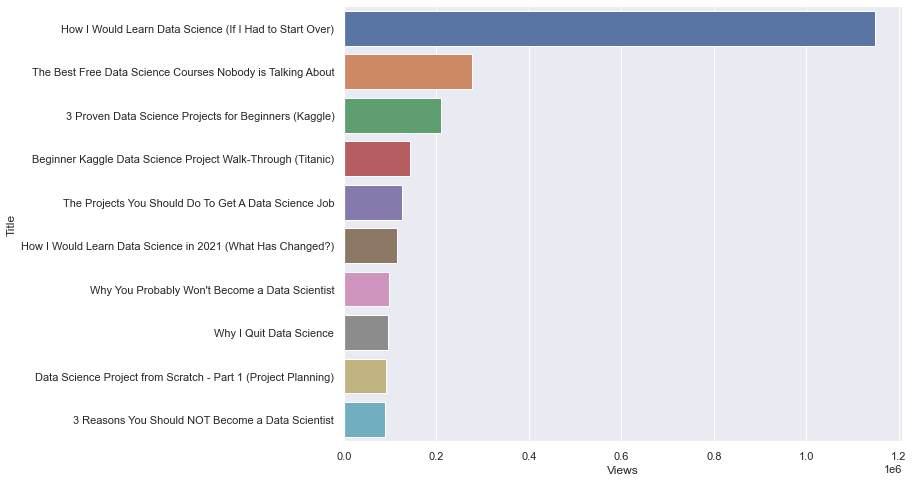

In [22]:
ax1 = sns.barplot(x='Views', y='Title', data=top10_videos)

In [23]:
video_data

,Title,Published_date,Views,Likes,Dislikes,Comments
0,#66DaysOfData Round 3 Live Event! (feat. @Stat...,2021-10-12,1222,108,0,3
1,My First Data Science Project (What Really Hap...,2021-10-08,2123,154,0,56
2,Is Data Visualization Important for Data Scien...,2021-08-20,9180,444,1,115
3,Project Presentation - Expectations vs. Realit...,2021-08-07,4421,162,2,36
4,Data Science Project - Expectations vs Reality...,2021-08-06,5474,198,5,18
...,...,...,...,...,...,...
202,How to Simulate NBA Games in Python,2018-11-19,12818,293,1,48
203,Should You Get A Masters in Data Science?,2018-11-14,17273,263,9,136
204,How I Became A Data Scientist From a Business ...,2018-11-12,5203,156,3,23
205,Predicting Season Long NBA Wins Using Multiple...,2018-07-10,6277,144,2,17


In [24]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')

In [25]:
video_data

,Title,Published_date,Views,Likes,Dislikes,Comments,Month
0,#66DaysOfData Round 3 Live Event! (feat. @Stat...,2021-10-12,1222,108,0,3,Oct
1,My First Data Science Project (What Really Hap...,2021-10-08,2123,154,0,56,Oct
2,Is Data Visualization Important for Data Scien...,2021-08-20,9180,444,1,115,Aug
3,Project Presentation - Expectations vs. Realit...,2021-08-07,4421,162,2,36,Aug
4,Data Science Project - Expectations vs Reality...,2021-08-06,5474,198,5,18,Aug
...,...,...,...,...,...,...,...
202,How to Simulate NBA Games in Python,2018-11-19,12818,293,1,48,Nov
203,Should You Get A Masters in Data Science?,2018-11-14,17273,263,9,136,Nov
204,How I Became A Data Scientist From a Business ...,2018-11-12,5203,156,3,23,Nov
205,Predicting Season Long NBA Wins Using Multiple...,2018-07-10,6277,144,2,17,Jul


In [26]:
videos_per_month = video_data.groupby('Month', as_index=False).size()

In [27]:
videos_per_month

,Month,size
0,Apr,19
1,Aug,21
2,Dec,15
3,Feb,13
4,Jan,14
5,Jul,24
6,Jun,17
7,Mar,20
8,May,19
9,Nov,15


In [28]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [29]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)

In [30]:
videos_per_month = videos_per_month.sort_index()

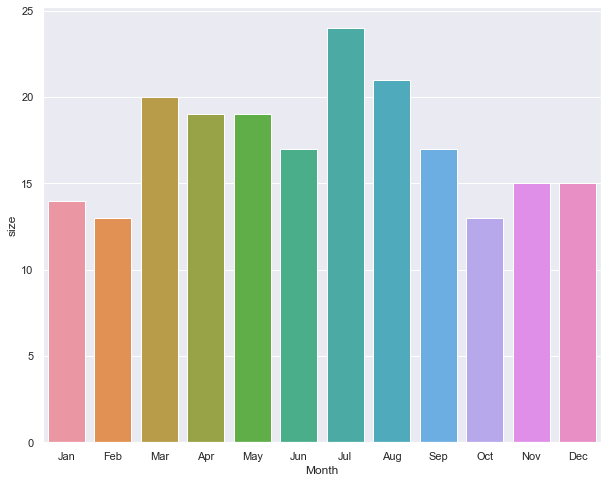

In [31]:
ax2 = sns.barplot(x='Month', y='size', data=videos_per_month)

In [32]:
video_data.to_csv('Video_Details(Ken Jee).csv')